In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

Feature Selection = reduce the number of features on the dataset by selection the most relevant ones
Feature Extraction = reduce the number of features by projecting the data into a lower dimensional feature space

# Principal Component Analysis (PCA)

$$\vec{x} W = \vec{z}$$

$\vec{x} \in \mathbb{R}^{d}$ = original feature vector with $d$ dimensions
$W \in \mathbb{R}^{d \times k}$ = PCA transformation matrix (eigenvectors)
$\vec{z} \in \mathbb{R}^{k}$ = transformed feature vector with $k$ dimensions

## PCA Step-by-Step 


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


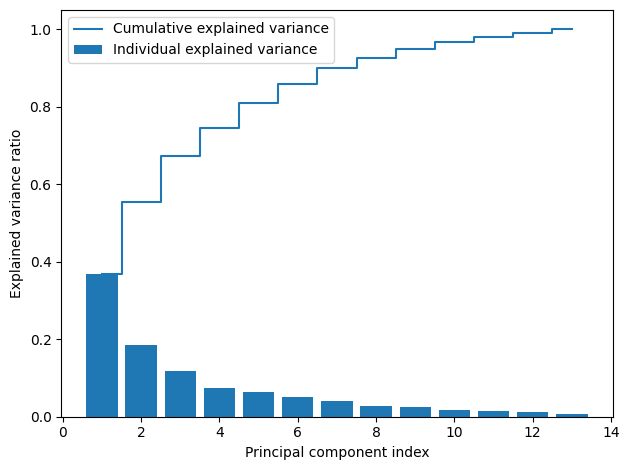

In [37]:
# PCA step by step

# Load dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# Split dataset into training and test sets
# First column is the class label, the rest are features
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# Standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Covariance matrix used to compute eigenvectors and eigenvalues
# Symmetric matrices (like covariance) do not result in eigenvalues with complex components
cov_mat = np.cov(X_train_std.T)

# Compute eigenvalues and eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n', eigen_vals)

# Plotted variance explained ratios
# The graph shows that 40% of the variance is explained by the first principal component
# and 60% by the first two principal components
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,14), var_exp, align='center', label='Individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [38]:
# Sort eigenvalues in decreasing order
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Select k eigenvectors that correspond to the k largest eigenvalues, in this case k=2
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W (d x k):\n', w)

# Projecting a single example onto the PCA subspace
print('Project example:\n', X_train_std[0].dot(w))

Matrix W (d x k):
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]
Project example:
 [2.38299011 0.45458499]


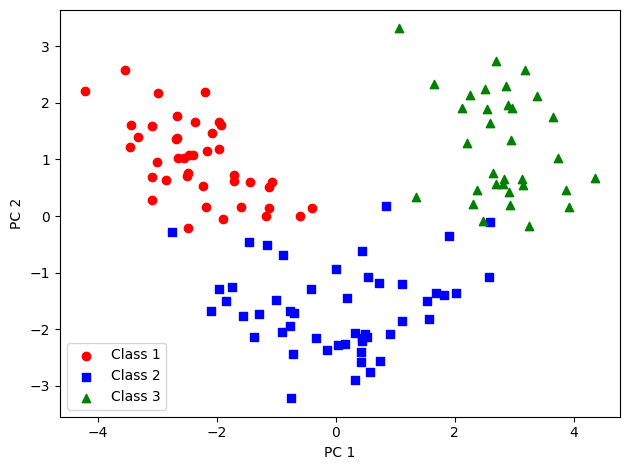

In [39]:
# Transform the entire training dataset
X_train_pca = X_train_std.dot(w)

# Plot transformed dataset
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=f'Class {l}', marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# PCA in Scikit-Learn

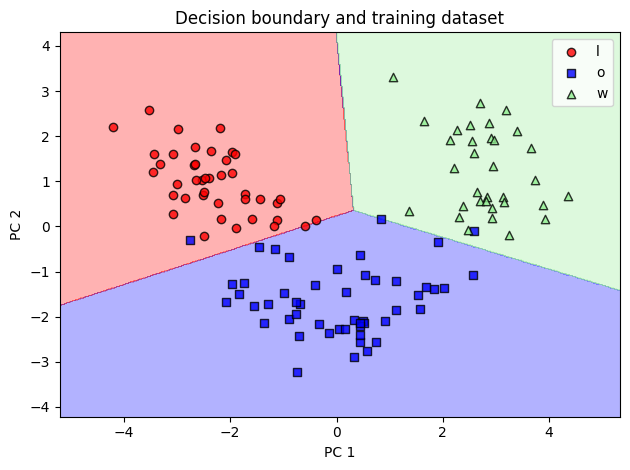

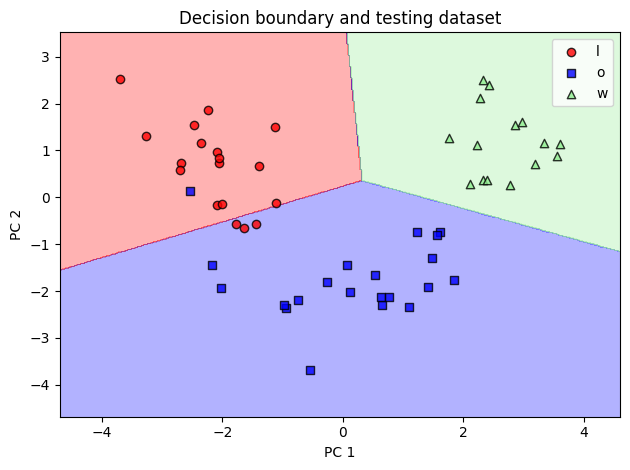

In [40]:
# "Model"
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')

# Dimensionality Reduction
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Fitting the model
lr.fit(X_train_pca, y_train)

# Decision boundary and training dataset
utils.plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend("lower left")
plt.title("Decision boundary and training dataset")
plt.tight_layout()
plt.show()

# Decision boundary and testing dataset
utils.plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend("lower left")
plt.title("Decision boundary and testing dataset")
plt.tight_layout()
plt.show()

### PCA assessing features contribution

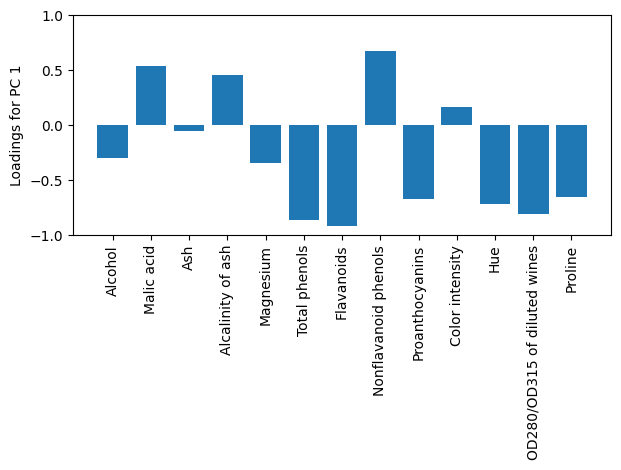

In [45]:
# For each PCA dimension the following equation allows us to see how much each feature contributes
# to the total variance of that PCA dimension (eigenvalues). This feature variance contribution is
# usually referred to as loading.
# Calculate for our manual PCA using numpy.
loadings = eigen_vecs * np.sqrt(eigen_vals)

# Plot the loadings for the first principal component, in this case loadings[:, 0]
# We can see that alcohol is negatively correlated with this feature, while malic
# acid is positive correlated.
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

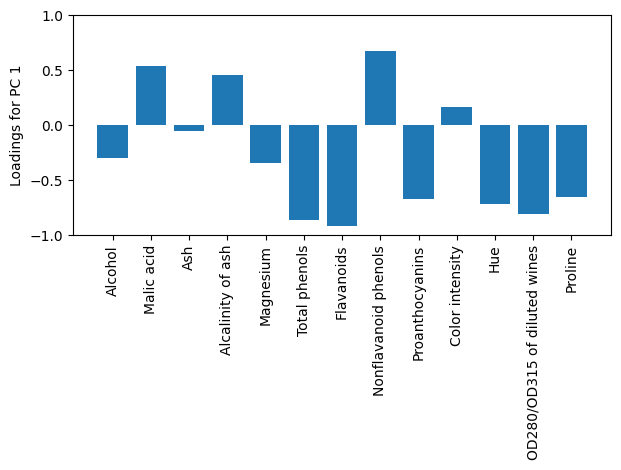

In [48]:
# Calculating loadings for PCA obtained via scikit-learn
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Similarly plot the loadings for the PC 1
fix, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()